In [1]:
# My first ML Model on the concept of Logistic Regression
# - Jitesh Krishna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from tqdm import tqdm

print('loaded all dependencies sucessfully')

loaded all dependencies sucessfully


In [3]:
# User-defined functions to be used later


def sigmoid(z):
    return 1/(1+np.exp(-z))
# Used as activation function during training


def calculate_loss(y_pred, Y):
    return ((-((Y*np.log(y_pred)) + ((1-Y)*np.log(1-y_pred)))).sum())/(len(Y))
# Used for calculating Cross-Entropy Loss during training


def Test(dataset, weights, bias, threshold):
    
    x = np.array(dataset['vector'].tolist())
    y = np.array(dataset['label'],dtype='float')
    y = y.reshape(len(y),1)
    z = np.dot(x, weights) + bias
    y_pred = sigmoid(z)
    TP = TN = FP = FN = 0
    for i in range(len(y_pred)):
        result = 1 if y_pred[i]>=threshold else 0
        # print('\n',result,validation.loc[i,'label'],'\n')
        
        if (result==1) and (y[i]==1):
            TP += 1
        if (result==1) and (y[i]==0):
            FP += 1
        if (result==0) and (y[i]==1):
            FN += 1
        if (result==0) and (y[i]==0):
            TN += 1
    return (TP,TN,FP,FN)
# Used to for Validation Tests during training and Final test after training


def getStats(TP,TN,FP,FN):
    accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
    precision = (TP/(TP+FP))*100
    recall = (TP/(TP+FN))*100
    false_alarm = (FP/(TP+FP))*100
    F1 = 2*((precision*recall)/(precision+recall))
    return (accuracy, precision, recall, false_alarm, F1)
# Used to get resultant metrics of the training to analyze the training outcome


def tokenize(text):
    return re.findall(r'\b[a-z]+\b', text.lower())
# Used to tokenize sentences (convert sentences into Token vectors)


def text_to_vector(text, vocab):

    vector = np.zeros(len(vocab), dtype=int)

    for token in text:
        if token in vocab:
            index = vocab[token]
            vector[index] += 1
    
    return vector
# Used for converting token vectors to numerical vectors (implementation of Bag of Words)

In [4]:
# Taking a look into the Dataset

data = pd.read_csv('SMSSpamCollection.csv', sep='\t')
print('Raw Dataset :-\n',data.head())

print('\nData Types of Dataset :-\n',data.dtypes)

print('\nShape of the Dataset : ',data.shape)

print('\nDuplicated Values in the Dataset : ',data.duplicated().sum())

print('\nNaN Entries in the Dataset :-\n',data.isna().sum())

total = len(data)
spam_percentage = (((data['label']=='spam').sum())/total)*100
ham_percentage = (((data['label']=='ham').sum())/total)*100

print(f'\nPercentage of Spam Data : {spam_percentage:.2f}%\nPercentage of Ham Data : {ham_percentage:.2f}%')

Raw Dataset :-
   label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Data Types of Dataset :-
 label      object
message    object
dtype: object

Shape of the Dataset :  (5572, 2)

Duplicated Values in the Dataset :  403

NaN Entries in the Dataset :-
 label      0
message    0
dtype: int64

Percentage of Spam Data : 13.41%
Percentage of Ham Data : 86.59%


In [5]:
# Cleaning the Dataset

data_cleaned = data.copy()

# Converting to Lowercase
data_cleaned['message'] = data_cleaned['message'].str.lower()

# Removing whitespace in the beginning and end of a message
data_cleaned['message'] = data_cleaned['message'].str.strip()

# Removing Punctuation
data_cleaned['message'] = data_cleaned['message'].str.translate(str.maketrans('','',string.punctuation))

# Removing Numbers
data_cleaned['message'] = data_cleaned['message'].str.replace(r'\d+','',regex=True)

# Removing Duplicated Values
data_cleaned.drop_duplicates(subset='message',inplace=True)

# Converting 'spam' to 1 and 'ham' to 0
data_cleaned['label'] = data_cleaned['label'].map({'spam':1,'ham':0})

print('dataset cleaned sucessfully')

dataset cleaned sucessfully


In [6]:
# Tokenizing the messages

data_cleaned['tokens'] = data_cleaned['message'].apply(tokenize)
print(data_cleaned.head(6))

# Creating a Vocabulary
words = set()

for tokens in data_cleaned['tokens']:
    words.update(tokens)

words = sorted(words)

Vocab = {word:idx for idx,word in enumerate(words)}

Data = data_cleaned.copy()
Data['vector'] = Data['tokens'].apply(lambda tokens: text_to_vector(tokens, Vocab))

print(Data.head())

   label                                            message  \
0      0  go until jurong point crazy available only in ...   
1      0                            ok lar joking wif u oni   
2      1  free entry in  a wkly comp to win fa cup final...   
3      0        u dun say so early hor u c already then say   
4      0  nah i dont think he goes to usf he lives aroun...   
5      1  freemsg hey there darling its been  weeks now ...   

                                              tokens  
0  [go, until, jurong, point, crazy, available, o...  
1                     [ok, lar, joking, wif, u, oni]  
2  [free, entry, in, a, wkly, comp, to, win, fa, ...  
3  [u, dun, say, so, early, hor, u, c, already, t...  
4  [nah, i, dont, think, he, goes, to, usf, he, l...  
5  [freemsg, hey, there, darling, its, been, week...  
   label                                            message  \
0      0  go until jurong point crazy available only in ...   
1      0                            ok lar joki

In [7]:
# Saving the Final Dataset to be used for the training

Data.to_csv('Cleaned_Spam_Dataset.csv',index=False)
print('saved CSV file sucessfully')

saved CSV file sucessfully


In [8]:
# Splitting the Dataset into Training, Validation and Test set

# Extracting Spam and Ham messages from the Dataset
spam_list = Data[Data['label']==1]
ham_list = Data[Data['label']==0]

# Undersampling ham_list as the dataset is heavily unbalanced
undersample_percentage = 0.7
rows_to_drop = int(undersample_percentage*len(ham_list))
drop_indices = np.random.choice(ham_list.index, rows_to_drop, replace=False)
ham_list = ham_list.drop(drop_indices)

# Shuffling the spam and ham lists
spam_list = spam_list.sample(frac=1).reset_index(drop=True)
ham_list = ham_list.sample(frac=1).reset_index(drop=True)
print('Shuffled spam and ham lists sucessfully')

# Splitting
train_size = 0.75
valid_size = 0.15
test_size = 0.15

num_spam = len(spam_list)
num_ham = len(ham_list)

train_spam = int(train_size*num_spam)
val_spam = int(valid_size*num_spam)
test_spam = num_spam - train_spam - val_spam

train_ham = int(train_size*num_ham)
val_ham = int(valid_size*num_ham)
test_ham = num_ham - train_ham - val_ham

training = pd.concat([spam_list[:train_spam],ham_list[:train_ham]],ignore_index=True)
validation = pd.concat([spam_list[train_spam:train_spam + val_spam],ham_list[train_ham:train_ham + val_ham]],ignore_index=True)
test = pd.concat([spam_list[-test_spam:],ham_list[-test_ham:]],ignore_index=True)

print('Splitted the Dataset sucessfully')

training = training.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

print('Shuffled the Training, Validation and Test subsets sucessfully')

print(f'\n\n\nTraining Set:-\n\nShape : {training.shape}')
print(f'Spam Percentage : {((((training['label']==1).sum())/(len(training)))*100):.2f}%')
print(f'Ham Percentage : {((((training['label']==0).sum())/(len(training)))*100):.2f}%')

print(f'\n\nValidation Set:-\n\nShape : {validation.shape}')
print(f'Spam Percentage : {((((validation['label']==1).sum())/(len(validation)))*100):.2f}%')
print(f'Ham Percentage : {((((validation['label']==0).sum())/(len(validation)))*100):.2f}%')

print(f'\n\nTest Set:-\n\nShape : {test.shape}')
print(f'Spam Percentage : {((((test['label']==1).sum())/(len(test)))*100):.2f}%')
print(f'Ham Percentage : {((((test['label']==0).sum())/(len(test)))*100):.2f}%')

Shuffled spam and ham lists sucessfully
Splitted the Dataset sucessfully
Shuffled the Training, Validation and Test subsets sucessfully



Training Set:-

Shape : (1466, 4)
Spam Percentage : 30.97%
Ham Percentage : 69.03%


Validation Set:-

Shape : (292, 4)
Spam Percentage : 30.82%
Ham Percentage : 69.18%


Test Set:-

Shape : (198, 4)
Spam Percentage : 31.31%
Ham Percentage : 68.69%


In [9]:
# Inititalizing weights and bias

weights = np.zeros((len(Vocab),1))
bias = 0.0

print('Initialized weights and bias')

Initialized weights and bias


 20%|████████████████                                                                | 100/500 [00:25<01:41,  3.93it/s]

Epoch 100 completed
Loss = 0.1012

Validation Test Analysis :-
Accuracy = 93.49
Precision = 87.37
Recall = 92.22
False Alarm = 12.63
F1 Score : 89.73




 40%|████████████████████████████████                                                | 200/500 [00:52<01:29,  3.33it/s]

Epoch 200 completed
Loss = 0.0758

Validation Test Analysis :-
Accuracy = 95.21
Precision = 93.18
Recall = 91.11
False Alarm = 6.82
F1 Score : 92.13




 60%|████████████████████████████████████████████████                                | 300/500 [01:14<00:43,  4.61it/s]

Epoch 300 completed
Loss = 0.0636

Validation Test Analysis :-
Accuracy = 95.21
Precision = 93.18
Recall = 91.11
False Alarm = 6.82
F1 Score : 92.13




 80%|████████████████████████████████████████████████████████████████                | 400/500 [01:35<00:21,  4.66it/s]

Epoch 400 completed
Loss = 0.0559

Validation Test Analysis :-
Accuracy = 95.55
Precision = 94.25
Recall = 91.11
False Alarm = 5.75
F1 Score : 92.66




100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:56<00:00,  4.31it/s]

Epoch 500 completed
Loss = 0.0504

Validation Test Analysis :-
Accuracy = 95.21
Precision = 94.19
Recall = 90.00
False Alarm = 5.81
F1 Score : 92.05




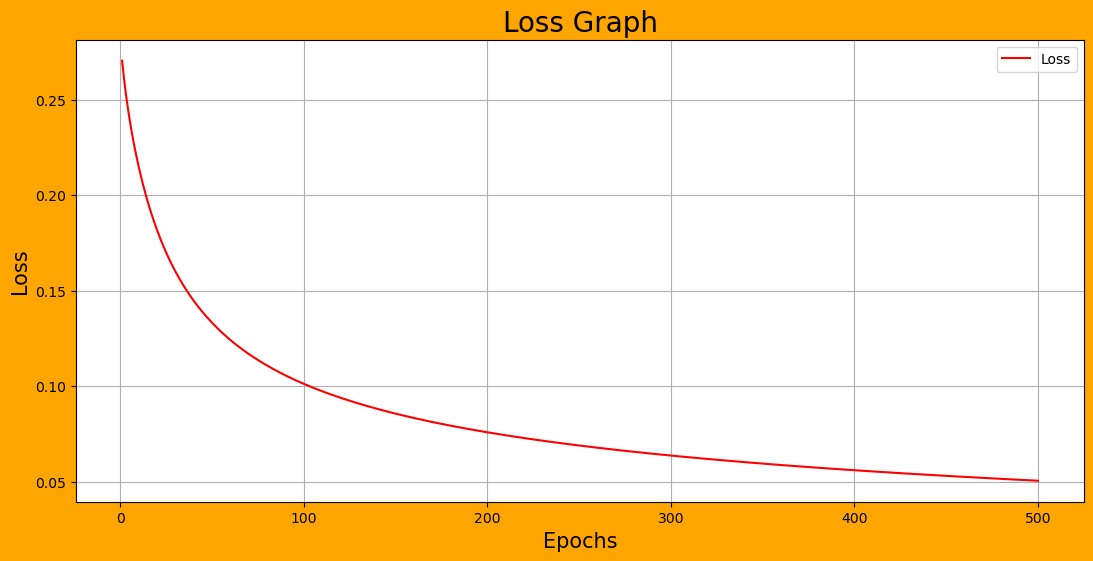

In [10]:
# Hyperparameters
lr = 0.01
batch_size = 64
epochs = 500
threshold = 0.3

# Extracting feature and label from Training subset
X = np.array(training['vector'].tolist())
Y = np.array(training['label'],dtype='float')
Y = Y.reshape(len(Y),1)
epoch_loss = []

# Gradient Descent
for epoch in tqdm(range(epochs)):
    
    # Shuffling Training subset at the start of each epoch
    training = training.sample(frac=1).reset_index(drop=True)
    batch_loss = []
    size = 0

    # Iterating over Batches
    for i in range(0,len(training),batch_size):

        X_batch = X[i:i+batch_size]
        Y_batch = Y[i:i+batch_size]
        size = len(X_batch)

        # Predicting Output
        z = np.dot(X_batch, weights) + bias
        y_predicted = sigmoid(z)

        # To avoid log(0) while computing Loss
        epsilon = 1e-15  # a very small number
        y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)

        error = y_predicted - Y_batch
        dW = (1/size) * (np.dot(X_batch.T,error))
        dB = (1/size) * (np.sum(error))

        # Updating weights and bias using their gradients
        weights -= lr*dW
        bias -= lr*dB
        batch_loss.append(calculate_loss(y_predicted,Y_batch))
        
    loss = sum(batch_loss)/size
    epoch_loss.append(loss)

    # Conducting Validation Test every 100 Epochs
    if ((epoch+1)%100==0):
        TP, TN, FP, FN = Test(validation, weights, bias, threshold)
        accuracy, precision, recall, false_alarm, F1 = getStats(TP, TN, FP, FN)
        print(f'Epoch {epoch+1} completed\nLoss = {loss:.4f}\n')
        print(f'Validation Test Analysis :-\nAccuracy = {accuracy:.2f}\nPrecision = {precision:.2f}\nRecall = {recall:.2f}')
        print(f'False Alarm = {false_alarm:.2f}\nF1 Score : {F1:.2f}\n\n')

# Plotting the Loss Graph
plt.figure(figsize=(13,6),facecolor='orange')
plt.plot(np.linspace(1,epochs,epochs),epoch_loss,'r-',label='Loss')
plt.grid(True)
plt.title("Loss Graph",fontsize=20)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.legend(loc='best')
plt.show()

In [25]:
# Final Test

TP, TN, FP, FN = Test(test, weights, bias, threshold)
accuracy, precision, recall, false_alarm, F1 = getStats(TP, TN, FP, FN)
print(f'Final Test Analysis :-\nAccuracy = {accuracy:.2f}\nPrecision = {precision:.2f}\nRecall = {recall:.2f}')
print(f'False Alarm = {false_alarm:.2f}\nF1 Score : {F1:.2f}\n\n')


Final Test Analysis :-
Accuracy = 95.45
Precision = 96.49
Recall = 88.71
False Alarm = 3.51
F1 Score : 92.44


